# blazers - Engineered features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 5 # blazers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(27495, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27495 entries, 0 to 27494
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            27495 non-null  int64  
 1   dimCustomerMasterId     27495 non-null  int64  
 2   customerNumber          27495 non-null  object 
 3   year                    27495 non-null  int64  
 4   productGrouping         27495 non-null  object 
 5   totalSpent              27495 non-null  float64
 6   recentDate              27495 non-null  object 
 7   attendancePercent       27495 non-null  float64
 8   renewedBeforeDays       27495 non-null  int64  
 9   isBuyer                 27495 non-null  object 
 10  source_tenure           27495 non-null  int64  
 11  tenure                  27495 non-null  int64  
 12  distToVenue             0 non-null      object 
 13  totalGames              27495 non-null  int64  
 14  recency                 27495 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
            "totalSpent",
        "renewedBeforeDays",
        "tenure",
        "source_tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "click_link",
        "fill_out_form",
        "open_email",
        "send_email",
        "openToSendRatio",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (18593, 18)
Unseen Data For Predictions: (3281, 18)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
              "totalSpent",
        "renewedBeforeDays",
        "tenure",
        "source_tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "click_link",
        "fill_out_form",
        "open_email",
        "send_email",
        "openToSendRatio",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8040,0.8721,0.8891,0.8198,0.8530,0.5604,0.5648,1.6070
lr,Logistic Regression,0.7827,0.8487,0.8508,0.8171,0.8335,0.5211,0.5222,0.6190


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7938,0.8697,0.8813,0.8122,0.8454,0.5376,0.5416
1,0.8178,0.8877,0.8863,0.8382,0.8615,0.5960,0.5980
2,0.7913,0.8619,0.8853,0.8070,0.8443,0.5297,0.5349
3,0.7982,0.8696,0.8764,0.8204,0.8474,0.5505,0.5532
4,0.8108,0.8754,0.8950,0.8241,0.8581,0.5756,0.5800
5,0.8070,0.8812,0.8842,0.8261,0.8541,0.5698,0.5727
6,0.8089,0.8742,0.8980,0.8201,0.8573,0.5698,0.5752
7,0.8076,0.8715,0.8990,0.8180,0.8566,0.5663,0.5721
8,0.8025,0.8713,0.8783,0.8245,0.8506,0.5604,0.5628
9,0.8019,0.8584,0.9070,0.8072,0.8542,0.5485,0.5576


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5621, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
21874,5,779,123258,2021,Full Season,4162.4,2022-02-27,0.900000,270,TRUE,...,0,0,0.0,1,189,0,1,1,0.0774,0.9226
21875,5,954,105944,2021,Full Season,24682.0,2022-02-27,0.728571,269,TRUE,...,0,0,0.0,1,189,0,1,1,0.4806,0.5194
21876,5,1916,190502547,2021,Full Season,5160.0,2022-02-24,0.735714,269,TRUE,...,0,0,0.0,1,189,0,1,1,0.2221,0.7779
21877,5,2416,130118860,2021,Half Season,1247.4,2022-02-08,0.718750,276,TRUE,...,0,0,0.0,1,189,0,1,0,0.8988,0.1012
21878,5,6322,190235554,2021,Half Season,1663.2,2022-02-24,0.823529,276,TRUE,...,0,0,0.0,1,189,0,1,0,0.6999,0.3001


In [11]:
new_predictions["Label"].value_counts()

1    2960
0    2661
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.4, 0.6]       1299
(0.6, 0.8]       1295
(0.2, 0.4]       1106
(0.8, 1.0]       1006
(-0.001, 0.2]     915
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

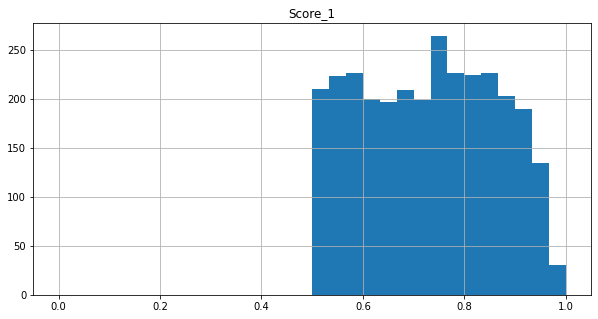

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

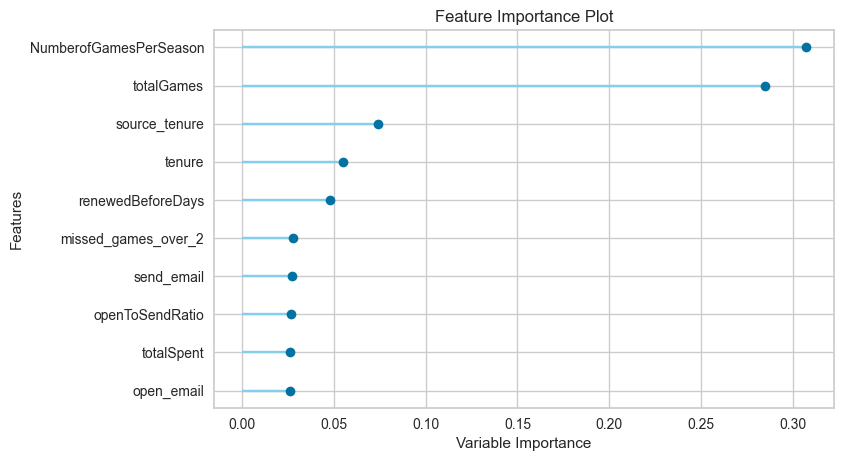

In [14]:
plot_model(best_model, plot='feature')

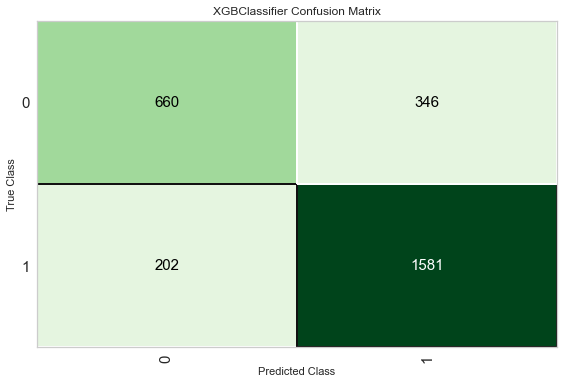

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?